In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import permutations

from deap import base
from deap import tools
from deap import creator
from deap import algorithms

# Algoritmos genéticos

- É uma classe de algoritmos usada, em geral, para resolver problemas de otimização cuja solução exata seja computacionalmente muito custosa de encontrar. Assim, a ideia é encontrar uma solução <em>boa</em>, mas não necessariamente <em>ótima</em> (no sentido matemático: a melhor possível).


- Existem vários tipos, mas a ideia básica é gerar um monte de soluções tentativas pro problema e combinar aquelas
que se mostrem as melhores pra gerar novas soluções que sejam melhores ainda.


- O nome vem da inspiração biológica: "genes" mais "adaptados ao ambiente" (isto é, soluções mais próximas da solução ótima) tendem a se propagar na população, fazendo com que as características mais adaptadas àquele ambiente se tornem dominantes com o passar das gerações.

![](Genes.png)

#  Um pouco de teoria sobre

Precisamos definir algumas coisas:

- Uma função de adequação (<em><b>fitness</b></em>) que esteja relacionada com o que queremos otimizar. 
    - Por exemplo, $f(x) = x^4+x^3+x^2+7x+2000 \sin{(x)}$, cujo mínimo global é em $x \approx -1.57$. 
    

- As características (os <em><b>genes</b></em>) de uma solução proposta (um indivíduo).
    - No caso, o ponto $x$ da solução.
    
    
- Uma <em><b>população</b></em> desses indivíduos.
    - $N$ pontos $x_i$.
    
    
- Uma maneira de <em><b>mutar</b></em> esses indivíduos pra que eles possivelmente se aproximem da solução ótima.
    - Por exemplo, adicionar ou subtrair um valor pequeno em $x_i$.
    
    
- Uma maneira de <em><b>selecionar</b></em> esses indivíduos pra que eles se aproximem da solução ótima.
    - Por exemplo, escolher $N/2$ valores de $X=\{x_i\}$ na população tais que o valor nesse conjunto, $f(X)$, seja o menor possível.
    
    
- Uma maneira de <em><b>gerar novos indivíduos</b></em> pra população a partir dos melhores da geração anterior.
    - Por exemplo, pra cada dois geradores $x_i$ e $x_j$ tomamos duas médias ponderadas, $x_1' = w_1 x_i + w_2 x_j$ e $x_2' = w_2 x_i + w_1 x_j$.

# DEAP (Distributed Evolutionary Algorithms in Python)

Vamos usar o DEAP, que é uma biblioteca do Python especializada em construir algoritmos genéticos.

O primeiro passo é traduzir o problema acima pras ferramentas do DEAP. Boa parte do código aqui saiu direto da documentação da biblioteca que vale a pena consultar (https://deap.readthedocs.io/en/master/index.html).


### Exemplo (1) - Otimizando a função $f(x)$ dada acima.

Vamos ver o formato da função, o que ajuda a entender a distinção entre solução boa/ótima explicada acima.

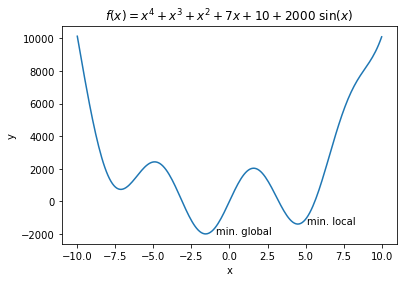

In [2]:
def eval_f(individual): 
    x = individual
    f = x**4+x**3+x**2+7*x+10+2000*np.sin(x)
    return (f,)

x=np.linspace(-10,10,200)
y=[eval_f(xi) for xi in x]

plt.plot(x,y)
plt.title('$f(x) = x^4 + x^3 + x^2 + 7 x +10 + 2000 \ \sin{(x)}$')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate(xy=(-0.8687,-1996),s='min. global')
plt.annotate(xy=(5.0912,-1392),s='min. local')
plt.show()

In [3]:
#Classes básicas que definem as propriedades do
#individuo

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #Aptidão da solução
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_gauss", np.random.normal, 100, 1) #Atributo básico do indivíduo
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_gauss, 1) #Gera um número
toolbox.register("population", tools.initRepeat, list, toolbox.individual) #Gera a população 

def eval_f(individual): 
    x = individual[0]
    f = x**4+x**3+x**2+7*x+10+2000*np.sin(x)
    return (f,)

def cross_x(child1,child2):
    child1[0]=0.3*child1[0]+0.7*child2[0]
    child2[0]=0.7*child1[0]+0.3*child2[0]

toolbox.register("evaluate", eval_f) #Calcula o fitness
toolbox.register("mate", cross_x)
toolbox.register("mutate", tools.mutGaussian, mu=0,sigma=2,indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

register=[]

def main():
    pop = toolbox.population(n=300)
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    CXPB, MUTPB = 0.5, 0.2
    fits = [ind.fitness.values[0] for ind in pop]

    g = 0

    while g < 1000:
        g = g + 1
        print("-- Generation %i --" % g)

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop[:]=offspring

        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
        register.append({'min':min(fits),'max':max(fits),'mean':mean,'std':std})
        
    return(pop)
        
pop=main()

-- Generation 1 --
  Min 90094944.68500495
  Max 105661073.23149978
  Avg 98109327.17141393
  Std 2629143.4119187947
-- Generation 2 --
  Min 87173367.73571602
  Max 99804084.63820276
  Avg 95627842.71179484
  Std 2019033.523341304
-- Generation 3 --
  Min 86650696.61735079
  Max 107360816.5013983
  Avg 93695753.41630882
  Std 1890558.2927320702
-- Generation 4 --
  Min 84897704.27197151
  Max 97106337.68870753
  Avg 92183650.45272727
  Std 1641545.803646368
-- Generation 5 --
  Min 75503821.75606537
  Max 93661437.77030768
  Avg 90900843.8777437
  Std 1661431.519820483
-- Generation 6 --
  Min 75503821.75606537
  Max 110255936.62370187
  Avg 89539676.83166842
  Std 2740142.6796513717
-- Generation 7 --
  Min 75503821.75606537
  Max 92322003.15260257
  Avg 87670254.64858018
  Std 2733742.496553397
-- Generation 8 --
  Min 75503821.75606537
  Max 105056541.83874594
  Avg 85883030.21835357
  Std 3482434.0400245916
-- Generation 9 --
  Min 57120370.43104042
  Max 88107532.11673808
  Avg 8

  Min 8334288.91361271
  Max 11250267.759405296
  Avg 10395158.222720563
  Std 614140.4699011253
-- Generation 82 --
  Min 8334288.91361271
  Max 11864820.234805137
  Avg 9869067.825180477
  Std 503890.4906504674
-- Generation 83 --
  Min 8334288.91361271
  Max 10245130.53546561
  Avg 9444540.72057704
  Std 361646.6611111943
-- Generation 84 --
  Min 8334288.91361271
  Max 9693634.704512782
  Avg 9142974.45473116
  Std 279796.686412345
-- Generation 85 --
  Min 7496138.553619089
  Max 10508666.443616658
  Avg 8898647.631391488
  Std 229775.03475866074
-- Generation 86 --
  Min 7061971.6299087005
  Max 9370966.605158048
  Avg 8700726.05533239
  Std 232697.0710466789
-- Generation 87 --
  Min 7061971.6299087005
  Max 10010530.563327633
  Avg 8537858.27336246
  Std 292160.07534269633
-- Generation 88 --
  Min 7061971.6299087005
  Max 10080192.498329177
  Avg 8342336.723521869
  Std 320440.8391831332
-- Generation 89 --
  Min 6076370.00153179
  Max 8879974.158966664
  Avg 8084048.444756837

  Min 37826.49495622474
  Max 89901.6514388355
  Avg 51581.37867485327
  Std 5405.234301458401
-- Generation 162 --
  Min 37826.49495622474
  Max 54144.17339934675
  Avg 47477.82161965623
  Std 3624.77303405507
-- Generation 163 --
  Min 14255.257600400935
  Max 110961.99638110402
  Avg 44665.34484291196
  Std 5461.822659180613
-- Generation 164 --
  Min 14255.257600400935
  Max 56008.490038136784
  Avg 40739.54550542539
  Std 5066.275460013718
-- Generation 165 --
  Min 10987.454928817559
  Max 49489.0577266429
  Avg 36513.94011234372
  Std 7155.948156517347
-- Generation 166 --
  Min 10987.454928817559
  Max 54150.076558147695
  Avg 31003.097635767244
  Std 8550.409468723083
-- Generation 167 --
  Min 10987.454928817559
  Max 38009.76513749192
  Avg 23195.915613945246
  Std 7051.3280088360625
-- Generation 168 --
  Min 10987.454928817559
  Max 30177.52070007988
  Avg 17731.579312309266
  Std 3598.148396575802
-- Generation 169 --
  Min 5803.164464860132
  Max 21849.003954928714
  Avg

  Min -1900.87350785539
  Max 1378.7799061470932
  Avg -1663.4427207532826
  Std 239.8576118998362
-- Generation 234 --
  Min -1994.6041380415952
  Max 2327.1950240134233
  Avg -1718.9664148879035
  Std 286.661998786785
-- Generation 235 --
  Min -1996.2435867847623
  Max -1104.964653026795
  Avg -1823.449407607579
  Std 81.14919027348441
-- Generation 236 --
  Min -1996.3199825160455
  Max -1673.2252239947563
  Avg -1891.1707924765503
  Std 61.49084003482614
-- Generation 237 --
  Min -1996.3199825160455
  Max 1941.9539297880365
  Avg -1923.106217417963
  Std 258.7857312430938
-- Generation 238 --
  Min -1996.3199825160455
  Max 250.93913278342384
  Avg -1959.917563362191
  Std 201.8565024497943
-- Generation 239 --
  Min -1996.3203397252698
  Max 1935.6189225937198
  Avg -1971.149744079808
  Std 261.5682317457541
-- Generation 240 --
  Min -1996.3203400204263
  Max 805.6962639823722
  Avg -1986.8798143433182
  Std 161.4990078552625
-- Generation 241 --
  Min -1996.3203400204263
  Max

  Min -1996.320340029519
  Max 1428.172773801476
  Avg -1969.9889632306963
  Std 250.22269302652373
-- Generation 312 --
  Min -1996.320340029519
  Max 1993.9603851920401
  Avg -1959.5602689710286
  Std 351.6526997829048
-- Generation 313 --
  Min -1996.320340029519
  Max 1725.640895808051
  Avg -1976.2956355081835
  Std 223.99187825237044
-- Generation 314 --
  Min -1996.320340029519
  Max -1569.8312179654336
  Avg -1994.8987096226529
  Std 24.582287750985113
-- Generation 315 --
  Min -1996.320340029519
  Max 1984.451539880289
  Avg -1973.9861212655378
  Std 247.63010355718114
-- Generation 316 --
  Min -1996.320340029519
  Max 2000.8981383230703
  Avg -1971.356304338241
  Std 305.4221361106223
-- Generation 317 --
  Min -1996.320340029519
  Max 2325.6463037306135
  Avg -1969.0276380967214
  Std 333.55323420066827
-- Generation 318 --
  Min -1996.320340029519
  Max 2027.0692843541667
  Avg -1982.3318298098561
  Std 232.02037727956215
-- Generation 319 --
  Min -1996.320340029519
  Ma

  Min -1996.320340029519
  Max 1992.456290363737
  Avg -1959.9067984474093
  Std 333.75381761638505
-- Generation 387 --
  Min -1996.320340029519
  Max -1996.3203400295185
  Avg -1996.3203400295333
  Std 0.0002114319833458102
-- Generation 388 --
  Min -1996.320340029519
  Max 803.0297264748843
  Avg -1972.9567459152934
  Std 236.63082553259656
-- Generation 389 --
  Min -1996.320340029519
  Max 2032.4550239746884
  Avg -1964.3032105150721
  Std 314.7892817966158
-- Generation 390 --
  Min -1996.320340029519
  Max 773.1576734971932
  Avg -1987.0887466511108
  Std 159.62917206767585
-- Generation 391 --
  Min -1996.320340029519
  Max 496.6447166916495
  Avg -1985.2345926256537
  Std 149.4654985586817
-- Generation 392 --
  Min -1996.320340029519
  Max -991.3307823609877
  Avg -1991.8863599689168
  Std 60.36746659433194
-- Generation 393 --
  Min -1996.320340029519
  Max -453.71381094699086
  Avg -1987.991169641857
  Std 103.02777588513898
-- Generation 394 --
  Min -1996.320340029519
  

  Min -1996.320340029519
  Max 2125.610453801689
  Avg -1961.974748130908
  Std 331.58681091296864
-- Generation 468 --
  Min -1996.320340029519
  Max 1991.7697189007474
  Avg -1953.7572538770812
  Std 388.99481781186716
-- Generation 469 --
  Min -1996.320340029519
  Max 2031.4961812985891
  Avg -1972.0039272756594
  Std 269.32345057674246
-- Generation 470 --
  Min -1996.320340029519
  Max 1648.9874367730142
  Avg -1974.6236171416042
  Std 266.75753161565103
-- Generation 471 --
  Min -1996.320340029519
  Max 1528.3789398722365
  Avg -1973.5828641758728
  Std 277.46482755408056
-- Generation 472 --
  Min -1996.320340029519
  Max 2001.4459384479667
  Avg -1941.860456593909
  Std 431.9815612100039
-- Generation 473 --
  Min -1996.320340029519
  Max 2009.7031596632064
  Avg -1972.9766092835694
  Std 283.2563044009888
-- Generation 474 --
  Min -1996.320340029519
  Max -147.94947048094772
  Avg -1985.2364117668274
  Std 136.14428065402274
-- Generation 475 --
  Min -1996.320340029519
  M

  Min -1996.320340029519
  Max -137.83527849532624
  Avg -1979.3139172673248
  Std 142.4934283362001
-- Generation 553 --
  Min -1996.320340029519
  Max 1770.324853907959
  Avg -1961.7423275395513
  Std 319.50004061538226
-- Generation 554 --
  Min -1996.320340029519
  Max 2309.7103120524876
  Avg -1950.024145023085
  Std 345.44021357822055
-- Generation 555 --
  Min -1996.320340029519
  Max 5.5805328488139025
  Avg -1985.4619402041515
  Std 129.2759750802619
-- Generation 556 --
  Min -1996.320340029519
  Max -1515.4670562162316
  Avg -1994.7174957501559
  Std 27.715768532575083
-- Generation 557 --
  Min -1996.320340029519
  Max 2390.4597884166647
  Avg -1968.5579855197466
  Std 339.3690113345613
-- Generation 558 --
  Min -1996.320340029519
  Max -1748.0654018130347
  Avg -1995.4928235688114
  Std 14.309097256413983
-- Generation 559 --
  Min -1996.320340029519
  Max 1795.241141072084
  Avg -1982.946779242366
  Std 218.86758596271508
-- Generation 560 --
  Min -1996.320340029519
  M

  Min -1996.320340029519
  Max 824.1958215773072
  Avg -1986.9186194908436
  Std 162.57094567343032
-- Generation 631 --
  Min -1996.320340029519
  Max -1605.872043033285
  Avg -1994.9149631246746
  Std 22.570525803043726
-- Generation 632 --
  Min -1996.320340029519
  Max 1938.3514226858993
  Avg -1970.7192583166718
  Std 304.4319483836369
-- Generation 633 --
  Min -1996.320340029519
  Max 1627.3844578787202
  Avg -1984.2413240365056
  Std 208.86571183547952
-- Generation 634 --
  Min -1996.320340029519
  Max 2002.1213429200193
  Avg -1968.3365646922182
  Std 303.637138529459
-- Generation 635 --
  Min -1996.320340029519
  Max 1937.2506649442746
  Avg -1967.228216064956
  Std 300.13821178622715
-- Generation 636 --
  Min -1996.320340029519
  Max 2257.7750201512235
  Avg -1982.1400221622641
  Std 245.20061792372599
-- Generation 637 --
  Min -1996.320340029519
  Max 1764.6908349826888
  Avg -1975.9040752336864
  Std 253.31336651509875
-- Generation 638 --
  Min -1996.320340029519
  Ma

  Min -1996.320340029519
  Max -431.9975960226238
  Avg -1991.1059308828437
  Std 90.16556306002074
-- Generation 717 --
  Min -1996.320340029519
  Max 343.50237282926736
  Avg -1974.0887341605987
  Std 193.32911782147727
-- Generation 718 --
  Min -1996.320340029519
  Max 1337.7197466789464
  Avg -1974.0528092824532
  Std 266.83742101274305
-- Generation 719 --
  Min -1996.320340029519
  Max -297.67063792637305
  Avg -1990.619050708427
  Std 97.90807184711643
-- Generation 720 --
  Min -1996.320340029519
  Max 1826.9901897461334
  Avg -1983.5759715969477
  Std 220.3707310348968
-- Generation 721 --
  Min -1996.320340029519
  Max 1677.3886770588706
  Avg -1969.5251904901754
  Std 250.13233457608837
-- Generation 722 --
  Min -1996.320340029519
  Max 2148.5884818896584
  Avg -1954.0174749552245
  Std 362.4181442927732
-- Generation 723 --
  Min -1996.320340029519
  Max 2154.0749934349087
  Avg -1976.5110138831358
  Std 249.66865031800472
-- Generation 724 --
  Min -1996.320340029519
  M

  Min -1996.320340029519
  Max -426.09092059843994
  Avg -1991.035058622797
  Std 90.50738360070946
-- Generation 800 --
  Min -1996.320340029519
  Max 2384.7191142382994
  Avg -1954.1406263932251
  Std 390.51231034454247
-- Generation 801 --
  Min -1996.320340029519
  Max 628.1677272566654
  Avg -1987.568591004213
  Std 151.2719488937828
-- Generation 802 --
  Min -1996.320340029519
  Max 2200.344799784576
  Avg -1980.3969637942791
  Std 244.08151378245066
-- Generation 803 --
  Min -1996.320340029519
  Max -759.0861468627219
  Avg -1992.1962260523105
  Std 71.31259715503465
-- Generation 804 --
  Min -1996.320340029519
  Max -1373.945488350412
  Avg -1992.5747759653104
  Std 41.37553054372042
-- Generation 805 --
  Min -1996.320340029519
  Max 1998.9837150687158
  Avg -1957.7384470186103
  Std 384.1687638471274
-- Generation 806 --
  Min -1996.320340029519
  Max 2005.3864244686806
  Avg -1976.3314810496065
  Std 244.63765481352974
-- Generation 807 --
  Min -1996.320340029519
  Max 1

  Min -1996.320340029519
  Max -493.00137397197676
  Avg -1990.2659167228378
  Std 88.44857499383664
-- Generation 883 --
  Min -1996.320340029519
  Max 175.04021099634753
  Avg -1988.7270342557479
  Std 125.284733887129
-- Generation 884 --
  Min -1996.320340029519
  Max -828.1570537808688
  Avg -1992.4256527292898
  Std 67.33139301441241
-- Generation 885 --
  Min -1996.320340029519
  Max -1966.8244281295983
  Avg -1996.2220203232
  Std 1.700106640113322
-- Generation 886 --
  Min -1996.320340029519
  Max 1248.6561952694954
  Avg -1980.200185563631
  Std 196.36631852442258
-- Generation 887 --
  Min -1996.320340029519
  Max 1869.2728955450493
  Avg -1982.1020609928999
  Std 223.35097770856373
-- Generation 888 --
  Min -1996.320340029519
  Max 764.4262234827963
  Avg -1986.256713869742
  Std 159.77149136318414
-- Generation 889 --
  Min -1996.320340029519
  Max -1996.320340029519
  Avg -1996.3203400295333
  Std 0.0002114319833458102
-- Generation 890 --
  Min -1996.320340029519
  Max

  Min -1996.320340029519
  Max 1745.4141733376123
  Avg -1983.8434132577645
  Std 215.66854865008682
-- Generation 960 --
  Min -1996.320340029519
  Max -1613.2112016425122
  Avg -1995.043309568243
  Std 22.081920950775817
-- Generation 961 --
  Min -1996.320340029519
  Max 1329.761534282785
  Avg -1984.598688386794
  Std 191.9075721117221
-- Generation 962 --
  Min -1996.320340029519
  Max 394.10958166628535
  Avg -1982.5962103218092
  Std 153.8859884955808
-- Generation 963 --
  Min -1996.320340029519
  Max -1996.320340029519
  Avg -1996.3203400295333
  Std 0.0002114319833458102
-- Generation 964 --
  Min -1996.320340029519
  Max 2329.2897514581846
  Avg -1970.2095354190503
  Std 284.86609359082024
-- Generation 965 --
  Min -1996.320340029519
  Max 1568.680728374135
  Avg -1975.5709472847536
  Std 247.64994697546499
-- Generation 966 --
  Min -1996.320340029519
  Max 701.0430782260801
  Avg -1984.1025875968944
  Std 165.00442826717247
-- Generation 967 --
  Min -1996.320340029519
  

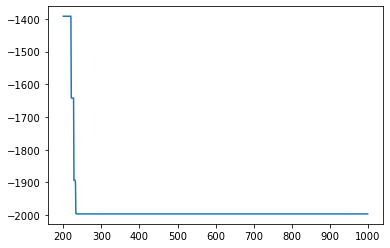

In [4]:
pd.DataFrame(register)['min'].iloc[200:].plot()

In [5]:
#Sol. exata
#x = -1.5687
#f = -1996.3203

print(tools.selBest(pop, k=1)[0])

eval_f(tools.selBest(pop, k=1)[0])

[-1.568698299817252]


(-1996.320340029519,)

### Exemplo (2) - Otimizando uma função com vínculos.

Vamos tentar otimizar $f(x,y) = 4x-y$ sujeita aos vínculos:
<ul>
<item>$7x-2y \leq 14$</item>
    
<item>$y \leq 3$</item>
    
<item>$ 2x-2y \leq 3$</item>
    
<item>$ x,y \geq 0$</item>
</ul>

In [6]:
creator.create("Fitness", base.Fitness, weights=(1.0,)) 
creator.create("Individual", list, fitness=creator.Fitness)

toolbox = base.Toolbox()
toolbox.register("attr_gauss", np.random.normal, 100, 1) #Atributo básico do indivíduo
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_gauss, 2) #Gera um número
toolbox.register("population", tools.initRepeat, list, toolbox.individual) #Gera a população 

def eval_f(individual): 
    x = individual[0]
    y = individual[1]
    f = 4*x-y
    return (f,)

def feasible(individual):

    x = individual[0]
    y = individual[1]
    
    if 7*x-2*y > 14:
        return False
    elif y > 3:
        return False
    elif 2*x-2*y > 3:
        return False
    elif x < 0 or y <0:
        return False
    return True

def distance(individual):
    return np.sqrt((individual[0]-4.5)**2+(individual[1] - 3.0)**2)

def cross_x(child1,child2):
    child1[0]=0.3*child1[0]+0.7*child2[0]
    child2[0]=0.7*child1[0]+0.3*child2[0]
    
    child1[1]=0.3*child1[1]+0.7*child2[1]
    child2[1]=0.7*child1[1]+0.3*child2[1]
    
def mutate(mutant):
    mutant[0]+=np.random.standard_cauchy()
    mutant[1]+=np.random.standard_cauchy()

toolbox.register("evaluate", eval_f) #Calcula o fitness
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0,distance))
toolbox.register("mate", cross_x)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

register=[]

def main():
    pop = toolbox.population(n=300)

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    CXPB, MUTPB = 0.5, 0.2
    fits = [ind.fitness.values[0] for ind in pop]

    g = 0

    
    while g < 1000:
        
        g = g + 1
        print("-- Generation %i --" % g)

        
        offspring = toolbox.select(pop, len(pop))
        
        offspring = list(map(toolbox.clone, offspring))

        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop[:]=offspring

        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
        register.append({'min':min(fits),'max':max(fits),'mean':mean,'std':std})
    return(pop)
        
pop = main()

/home/gabriel/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


-- Generation 1 --
  Min -151.46262735026897
  Max -124.06203642210622
  Avg -135.2308362761824
  Std 1.8843062656702267
-- Generation 2 --
  Min -16085.674728421107
  Max -112.82418796846255
  Avg -187.3812597253738
  Std 919.4262931407442
-- Generation 3 --
  Min -159.48049638254574
  Max -121.70904900030088
  Avg -132.66154347484726
  Std 3.246467741062284
-- Generation 4 --
  Min -152.62141076401008
  Max -97.20311347259711
  Avg -130.4183238643748
  Std 4.908823556411569
-- Generation 5 --
  Min -151.71350905844886
  Max -97.20311347259711
  Avg -127.04773189944368
  Std 6.5235667813677445
-- Generation 6 --
  Min -286.7089940271355
  Max -81.49776258288928
  Avg -123.46484156984607
  Std 13.162935873892502
-- Generation 7 --
  Min -150.46687161676186
  Max -78.31609242200479
  Avg -115.46624290573406
  Std 11.534851255823964
-- Generation 8 --
  Min -124.16786720730431
  Max -68.16383298813604
  Avg -103.35678329744796
  Std 12.34202188774742
-- Generation 9 --
  Min -129.5516106

  Min -141.51162814078603
  Max 8.404711897838256
  Avg 5.635938548895719
  Std 10.334586472394614
-- Generation 88 --
  Min -111.76262523577529
  Max 8.404711897838256
  Avg 3.9342040026933547
  Std 13.67130366116534
-- Generation 89 --
  Min -166.91881573403182
  Max 8.39278601292629
  Avg 5.23555962559468
  Std 12.366546112632703
-- Generation 90 --
  Min -35.66148804236577
  Max 8.39278601292629
  Avg 5.927553169891259
  Std 6.019644125964242
-- Generation 91 --
  Min -127.99316124640023
  Max 8.39278601292629
  Avg 5.308586217443476
  Std 9.665501494759601
-- Generation 92 --
  Min -874.8241719947778
  Max 8.39278601292629
  Avg 1.5524093447633722
  Std 56.03217384277625
-- Generation 93 --
  Min -229.1558716662344
  Max 8.389658847334479
  Avg 5.32773922386616
  Std 15.289827333198021
-- Generation 94 --
  Min -562.4661174027646
  Max 8.389658847334479
  Avg 3.090850265696374
  Std 39.00889662659002
-- Generation 95 --
  Min -35.23643889691368
  Max 8.389658847334479
  Avg 6.1925

  Min -66.05841185741967
  Max 8.389569466284513
  Avg 6.328324331923757
  Std 7.283289261676952
-- Generation 169 --
  Min -308.61282542761404
  Max 8.389569466284513
  Avg 4.140045586024604
  Std 19.749267528940287
-- Generation 170 --
  Min -1324.6880218175154
  Max 8.389569466284513
  Avg 1.5595281039955604
  Std 76.96180115750575
-- Generation 171 --
  Min -146.10237239783845
  Max 8.389569466284513
  Avg 5.425729877006691
  Std 10.769814910725266
-- Generation 172 --
  Min -806.8136004400448
  Max 8.389569466284513
  Avg 3.4346673860046386
  Std 47.1567956079419
-- Generation 173 --
  Min -834.9708880433045
  Max 8.389569466284513
  Avg 0.7550620178402401
  Std 63.37337630106721
-- Generation 174 --
  Min -135.91981615703853
  Max 8.389569466284513
  Avg 5.197071235473998
  Std 10.423396914324108
-- Generation 175 --
  Min -126.46739693124105
  Max 8.389569466284513
  Avg 4.524444063920342
  Std 10.819788071861076
-- Generation 176 --
  Min -644.7622011633309
  Max 8.389569466284

  Min -138.20748206985226
  Max 8.397141223209964
  Avg 5.483154509977492
  Std 9.949012196540753
-- Generation 250 --
  Min -254.6056793915497
  Max 8.397141223209964
  Avg 4.799121668064441
  Std 16.95548936388773
-- Generation 251 --
  Min -21.193274204260298
  Max 8.397141223209964
  Avg 6.044105175020218
  Std 5.119819882554369
-- Generation 252 --
  Min -150.9383595291666
  Max 8.397141223209964
  Avg 5.272178358005905
  Std 11.321479138027794
-- Generation 253 --
  Min -83.90513465013564
  Max 8.397141223209964
  Avg 5.526552122583762
  Std 7.5726908994295705
-- Generation 254 --
  Min -130.0262386264875
  Max 8.397141223209964
  Avg 5.309986679743925
  Std 9.547884234469667
-- Generation 255 --
  Min -79.55571190460428
  Max 8.397141223209964
  Avg 5.933029372975574
  Std 7.01386568980776
-- Generation 256 --
  Min -545.2956022474514
  Max 8.397141223209964
  Avg 4.0618084464174595
  Std 32.76315752552738
-- Generation 257 --
  Min -330.7746920504312
  Max 8.397141223209964
  A

  Min -28.72280327854666
  Max 8.397141223209964
  Avg 6.21705237739561
  Std 4.966284726701849
-- Generation 326 --
  Min -24.572574962048844
  Max 8.397141223209964
  Avg 6.035950366151058
  Std 5.413721966111035
-- Generation 327 --
  Min -19.222521753113504
  Max 8.397141223209964
  Avg 5.84601892536025
  Std 5.1198253027821625
-- Generation 328 --
  Min -161.38941008413804
  Max 8.397141223209964
  Avg 5.3747929991217935
  Std 11.502786667762505
-- Generation 329 --
  Min -245.82699652103076
  Max 8.397141223209964
  Avg 4.159952612594484
  Std 16.79763782409916
-- Generation 330 --
  Min -502.25162105020627
  Max 8.397141223209964
  Avg 4.351552705215156
  Std 29.960321088343836
-- Generation 331 --
  Min -263.8225497149135
  Max 8.397141223209964
  Avg 4.038179046512541
  Std 19.574103830446074
-- Generation 332 --
  Min -1176.3541951931982
  Max 8.397141223209964
  Avg 1.1849907488952582
  Std 68.98210990490692
-- Generation 333 --
  Min -43.5982158976283
  Max 8.39714122320996

  Min -39.70117399432946
  Max 8.40048412536413
  Avg 5.89739631014158
  Std 5.89899877003689
-- Generation 401 --
  Min -38.806899521902274
  Max 8.40048412536413
  Avg 5.9089779951887
  Std 6.253259052482592
-- Generation 402 --
  Min -55.11928089988817
  Max 8.40048412536413
  Avg 5.962567321968305
  Std 7.089973146659155
-- Generation 403 --
  Min -27.240535609885136
  Max 8.40048412536413
  Avg 5.474213616379138
  Std 6.360149552098799
-- Generation 404 --
  Min -75.8258319428373
  Max 8.40048412536413
  Avg 6.390665024507492
  Std 6.435572036089695
-- Generation 405 --
  Min -261.0158943004742
  Max 8.40048412536413
  Avg 5.227234154110655
  Std 16.535638216215407
-- Generation 406 --
  Min -546.7880070797113
  Max 8.40048412536413
  Avg 3.4649030114102835
  Std 33.22462298300258
-- Generation 407 --
  Min -391.61314977359865
  Max 8.40048412536413
  Avg 3.760511281098207
  Std 24.47993990653457
-- Generation 408 --
  Min -391.62402458589827
  Max 8.40048412536413
  Avg 4.4350707

  Min -346.2986791166629
  Max 8.40048412536413
  Avg 4.421540315941056
  Std 21.668949178264683
-- Generation 478 --
  Min -140.96357179390841
  Max 8.40048412536413
  Avg 5.243017540485966
  Std 10.683740687007925
-- Generation 479 --
  Min -427.50288613068733
  Max 8.40048412536413
  Avg 4.350701908789876
  Std 26.379225690458814
-- Generation 480 --
  Min -129.43107845367325
  Max 8.40048412536413
  Avg 5.013088729443896
  Std 10.332725288205022
-- Generation 481 --
  Min -574.0382380348823
  Max 8.40048412536413
  Avg 3.7890237564149984
  Std 34.428632659148484
-- Generation 482 --
  Min -4189.518410399786
  Max 8.40048412536413
  Avg -8.190921633109554
  Std 241.96714143679856
-- Generation 483 --
  Min -45.260664662080075
  Max 8.40048412536413
  Avg 6.37903050552034
  Std 5.44334865060672
-- Generation 484 --
  Min -375.0063776356323
  Max 8.40048412536413
  Avg 4.585324839523425
  Std 22.94879328380549
-- Generation 485 --
  Min -3465.192358125152
  Max 8.40048412536413
  Avg 

  Min -37.93107549877488
  Max 8.40048412536413
  Avg 5.918395907655032
  Std 6.213733639612772
-- Generation 561 --
  Min -17.000407154702778
  Max 8.40048412536413
  Avg 6.334722341727598
  Std 4.578678014174566
-- Generation 562 --
  Min -40.10776162646504
  Max 8.40048412536413
  Avg 5.63046276156553
  Std 6.410188812887726
-- Generation 563 --
  Min -241.72618749584794
  Max 8.40048412536413
  Avg 5.029012300942887
  Std 15.772391136012427
-- Generation 564 --
  Min -30.913225747886262
  Max 8.40048412536413
  Avg 5.831088139794975
  Std 6.054722878112768
-- Generation 565 --
  Min -176.02316992469116
  Max 8.40048412536413
  Avg 4.876151133163334
  Std 12.427523391421936
-- Generation 566 --
  Min -300.9756892570842
  Max 8.40048412536413
  Avg 4.59674763782972
  Std 22.200670579420898
-- Generation 567 --
  Min -349.950871371559
  Max 8.40048412536413
  Avg 4.666412166527187
  Std 21.29909284751578
-- Generation 568 --
  Min -265.86192326901994
  Max 8.40048412536413
  Avg 4.820

  Min -103.30795007473661
  Max 8.40048412536413
  Avg 5.164383132757481
  Std 8.413215123443734
-- Generation 634 --
  Min -69.65118749247259
  Max 8.40048412536413
  Avg 5.682424201640771
  Std 7.052631940169594
-- Generation 635 --
  Min -2258.269122094741
  Max 8.40048412536413
  Avg -1.989725899932499
  Std 130.87215601100309
-- Generation 636 --
  Min -67.34820390897727
  Max 8.40048412536413
  Avg 5.574901712819071
  Std 7.046714865937265
-- Generation 637 --
  Min -957.6338067243395
  Max 8.40048412536413
  Avg 0.7943127190275951
  Std 62.43689463581477
-- Generation 638 --
  Min -138.1573530925105
  Max 8.40048412536413
  Avg 4.440085360730442
  Std 13.335023128749812
-- Generation 639 --
  Min -15.68430476880908
  Max 8.40048412536413
  Avg 6.112414998991007
  Std 4.656263454123003
-- Generation 640 --
  Min -205.24798112558042
  Max 8.40048412536413
  Avg 5.006091677354552
  Std 13.566401642375851
-- Generation 641 --
  Min -92.18901642416739
  Max 8.40048412536413
  Avg 4.9

  Min -136.67185511122094
  Max 8.40048412536413
  Avg 4.79579004520042
  Std 13.876166226221962
-- Generation 709 --
  Min -79.1568394950786
  Max 8.40048412536413
  Avg 5.529431954858609
  Std 7.3993499382156935
-- Generation 710 --
  Min -123.66874170449039
  Max 8.40048412536413
  Avg 5.261034824282865
  Std 10.34517848458037
-- Generation 711 --
  Min -55.718333932123386
  Max 8.40048412536413
  Avg 5.37062389610372
  Std 8.024498629706866
-- Generation 712 --
  Min -46.1173118771132
  Max 8.40048412536413
  Avg 6.08159629085155
  Std 6.34903254605998
-- Generation 713 --
  Min -763.6239140106908
  Max 8.40048412536413
  Avg 1.5558338868413442
  Std 52.54552493036873
-- Generation 714 --
  Min -172.6773928401061
  Max 8.40048412536413
  Avg 4.867360458485608
  Std 12.296279717892862
-- Generation 715 --
  Min -571.3759177389438
  Max 8.40048412536413
  Avg 2.076641042718722
  Std 39.045060132798824
-- Generation 716 --
  Min -732.1093582015268
  Max 8.40048412536413
  Avg 2.949839

  Min -115.44038877388816
  Max 8.40048412536413
  Avg 5.044016618355575
  Std 9.347372557948816
-- Generation 792 --
  Min -28.5611839483766
  Max 8.40048412536413
  Avg 5.7182993988421
  Std 5.738179066953419
-- Generation 793 --
  Min -84.75625551003434
  Max 8.40048412536413
  Avg 4.891309054193948
  Std 8.265175372460314
-- Generation 794 --
  Min -200.8641385962592
  Max 8.40048412536413
  Avg 4.826455049501196
  Std 13.557127689085396
-- Generation 795 --
  Min -284.1844971066931
  Max 8.40048412536413
  Avg 5.1347688803547555
  Std 17.556047633299464
-- Generation 796 --
  Min -78.67784126345673
  Max 8.40048412536413
  Avg 5.203527417378933
  Std 9.066279319066687
-- Generation 797 --
  Min -286.97403155116814
  Max 8.40048412536413
  Avg 4.5860221615083345
  Std 19.633151525593448
-- Generation 798 --
  Min -48.414362255011014
  Max 8.40048412536413
  Avg 5.544525826120013
  Std 6.507715186055018
-- Generation 799 --
  Min -305.75517030297095
  Max 8.40048412536413
  Avg 4.64

  Min -90.94357037702223
  Max 8.40048412536413
  Avg 5.592910196373725
  Std 9.332352700602048
-- Generation 877 --
  Min -28.260732657098742
  Max 8.40048412536413
  Avg 5.9786249733213035
  Std 5.268478780366864
-- Generation 878 --
  Min -48.055329403976536
  Max 8.40048412536413
  Avg 5.464701674566685
  Std 7.17214959670522
-- Generation 879 --
  Min -1145.699427422547
  Max 8.40048412536413
  Avg -1.5383473381768817
  Std 78.53131950882174
-- Generation 880 --
  Min -32.69576926768414
  Max 8.40048412536413
  Avg 5.603304728451462
  Std 5.705586296527308
-- Generation 881 --
  Min -190.03708735602467
  Max 8.40048412536413
  Avg 4.929975791093849
  Std 13.001368701439432
-- Generation 882 --
  Min -39.151938183503006
  Max 8.40048412536413
  Avg 5.791799442681946
  Std 6.050710409735258
-- Generation 883 --
  Min -107.33614443608694
  Max 8.40048412536413
  Avg 5.9284393773831985
  Std 8.763376887293122
-- Generation 884 --
  Min -7676.863595951659
  Max 8.40048412536413
  Avg -

  Min -67.55248582307101
  Max 8.40048412536413
  Avg 5.498217069104485
  Std 7.5549304468723255
-- Generation 965 --
  Min -54.95631293463678
  Max 8.40048412536413
  Avg 5.716414022004355
  Std 6.660893151978841
-- Generation 966 --
  Min -783.4056570355158
  Max 8.40048412536413
  Avg 3.1669840332742076
  Std 45.88151252288963
-- Generation 967 --
  Min -156.72043635436074
  Max 8.40048412536413
  Avg 5.664578453502028
  Std 10.8046884327264
-- Generation 968 --
  Min -75.40874211546688
  Max 8.40048412536413
  Avg 5.375482682318427
  Std 7.420476559736566
-- Generation 969 --
  Min -69.68009453833038
  Max 8.40048412536413
  Avg 5.564030472991427
  Std 7.434481857369773
-- Generation 970 --
  Min -39.07262110571484
  Max 8.40048412536413
  Avg 5.19137083866361
  Std 6.891860710661492
-- Generation 971 --
  Min -122.15600020573777
  Max 8.40048412536413
  Avg 4.909788670297802
  Std 10.512687428121978
-- Generation 972 --
  Min -313.7730048926608
  Max 8.40048412536413
  Avg 4.94481

In [7]:
#Sol. exata: 
#x = 20/7 ~ 2.8571
#y = 3
#f = 59/7 ~ 8.4285

print(tools.selBest(pop, k=1)[0])

eval_f(tools.selBest(pop, k=1)[0])

[2.8309199644595218, 2.9231957324739564]


(8.40048412536413,)

### Exemplo (3) - O problema do caixeiro viajante.

O problema consiste em um conjunto de $n$ cidades e as distâncias $d$ entre elas. O objetivo é encontrar uma rota começando da cidade "0" que passe por todas as outras uma única vez e volte pra cidade original com a menor distância percorrida possível. 

A importância do problema do caixeiro viajante vem de que outros problemas podem ser colocados nesses termos, como escolher a melhor rota pra entrega de produtos de uma transportadora em uma cidade.

Um exemplo simétrico com 4 cidades (tirado da Wikipedia, https://en.wikipedia.org/wiki/Travelling_salesman_problem):

![](https://upload.wikimedia.org/wikipedia/commons/3/30/Weighted_K4.svg)

O número de combinações possíveis de serem exploradas é $O(n!)$, o que torna o problema intratável de ser resolvido exatamente (de fato, NP-hard).

No link (https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb) tem uma discussão legal sobre o problema, de onde também tirei alguns trechos de código pra usar abaixo

Vamos ver primeiro a solução força-bruta em um caso simples e depois a solução heurística usando um algoritmo genético. Aqui vamos considerar o problema assimétrico, onde as distâncias $d_{ij}$ não precisam ser iguais a $d_{ji}$.

In [8]:
n=8
d_matrix=np.random.randint(1,20,size=(n,n))

for i in range(n):
    d_matrix[i,i]=0
    
d_matrix

array([[ 0,  6,  2,  3, 19,  1, 13, 12],
       [ 3,  0, 15, 14,  2,  6, 12,  7],
       [16, 15,  0, 18, 17,  3, 11, 15],
       [ 9,  6,  9,  0,  9, 14,  8,  4],
       [ 7, 16, 13,  7,  0,  8, 12, 17],
       [ 9,  5,  6,  8, 18,  0, 12, 15],
       [ 4, 12,  9, 19, 19, 11,  0, 16],
       [ 1,  3,  8, 12,  7,  5,  2,  0]])

In [9]:
valid=[]
for perm in [*permutations([*range(n)]+[0],n+1)]:
    if perm[0]==0 and perm[-1]==0:
        valid.append(perm)    

valid=list(set(valid))
valid[0]

(0, 5, 7, 1, 6, 2, 4, 3, 0)

In [10]:
total_d=dict()

for road in valid:
    total_d[road]=sum([d_matrix[road[i],road[i+1]] for i in range(0,n)])

In [11]:
total_d

{(0, 5, 7, 1, 6, 2, 4, 3, 0): 73,
 (0, 2, 3, 1, 6, 7, 5, 4, 0): 84,
 (0, 4, 2, 1, 5, 7, 6, 3, 0): 98,
 (0, 1, 4, 2, 5, 6, 7, 3, 0): 73,
 (0, 6, 7, 5, 2, 4, 1, 3, 0): 96,
 (0, 6, 2, 1, 7, 3, 4, 5, 0): 82,
 (0, 2, 6, 5, 7, 3, 1, 4, 0): 66,
 (0, 1, 7, 2, 4, 5, 3, 6, 0): 66,
 (0, 5, 3, 6, 4, 1, 2, 7, 0): 83,
 (0, 5, 3, 4, 6, 1, 7, 2, 0): 73,
 (0, 4, 7, 2, 6, 3, 5, 1, 0): 96,
 (0, 1, 6, 4, 3, 5, 7, 2, 0): 97,
 (0, 6, 7, 3, 1, 4, 5, 2, 0): 79,
 (0, 2, 7, 6, 5, 1, 3, 4, 0): 65,
 (0, 2, 5, 7, 1, 3, 6, 4, 0): 71,
 (0, 2, 3, 5, 1, 4, 7, 6, 0): 64,
 (0, 7, 4, 5, 3, 6, 1, 2, 0): 86,
 (0, 3, 4, 5, 1, 6, 7, 2, 0): 77,
 (0, 1, 5, 6, 2, 3, 7, 4, 0): 69,
 (0, 3, 1, 2, 5, 6, 7, 4, 0): 69,
 (0, 6, 3, 2, 7, 1, 5, 4, 0): 90,
 (0, 7, 1, 5, 6, 2, 3, 4, 0): 76,
 (0, 5, 4, 2, 7, 6, 3, 1, 0): 77,
 (0, 5, 6, 2, 1, 3, 4, 7, 0): 78,
 (0, 7, 5, 6, 1, 4, 3, 2, 0): 75,
 (0, 7, 1, 5, 3, 2, 4, 6, 0): 71,
 (0, 5, 7, 2, 1, 6, 4, 3, 0): 86,
 (0, 4, 3, 6, 2, 7, 5, 1, 0): 71,
 (0, 6, 1, 2, 4, 7, 5, 3, 0): 96,
 (0, 4, 3, 5, 

In [12]:
min_d = np.inf
best_route = 0
for key, value in total_d.items():
    if value < min_d:
        min_d = value
        best_route=key
        
print(best_route)
print(min_d)

(0, 2, 5, 1, 4, 3, 7, 6, 0)
29


Agora vamos usar um algoritmo genético de maneira similar ao que fizemos antes. (Ainda não tá funcionando)

In [13]:
def create_route(n):
    route = random.sample([*range(0,n-1)],n-1)
    return route.copy()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("route", create_route, n)
toolbox.register("individual",  tools.initIterate, creator.Individual, toolbox.route) #Gera um número
toolbox.register("population", tools.initRepeat, list, toolbox.individual) #Gera a população 

def eval_f(individual): 
    road=[i+1 for i in individual]    
    fitness=(d_matrix[0,road[0]])+sum([d_matrix[road[i],road[i+1]] for i in range(0,n-2)])+d_matrix[road[-1],0]
    return(fitness,)

toolbox.register("evaluate", eval_f) #Calcula o fitness
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(100)
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=1000, verbose=False,stats=stats)

/home/gabriel/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [14]:
print([0]+[i+1 for i in tools.selBest(pop, k=1)[0]]+[0])

eval_f(tools.selBest(pop, k=1)[0])

[0, 2, 5, 1, 4, 3, 7, 6, 0]


(29,)

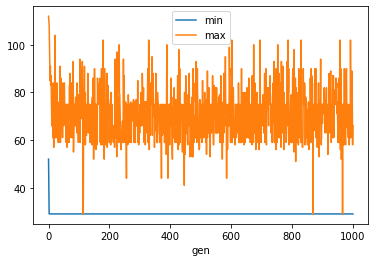

In [15]:
pd.DataFrame(log).plot(x='gen',y=['min','max'])